## LSGAN Implementation using Pytorch

In this notebook we are going to implement LSGAN to generate Bangla digits as well as characters. LSGAN is quite similar to the original GAN but just differentiates itself with respect to the Loss function.

So, lets start our project by first importing the necessary packages.

In [1]:
## Importing necessary packages ##

import torch
import torchvision
import torch.nn as nn

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

Now moving on lets import our dataset.

But we need to set our augmentations.

So what augmentation will we set?

- [ ] Resize to 64 , 64.
- [ ] Transform to Tensor.
- [ ] Normalize the tensor to [-1 , 1].

In [2]:
## Defining augmentation ##

aug = transforms.Compose([
    transforms.Resize((64 , 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5 , ) , std = (0.5 , ))
])

## Loading dataset ##

bangla_dataset = ImageFolder(root = 'BanglaLekha-Isolated//Images' , 
                             transform = aug)

## Checking the length of the dataset ##

print('The dataset has ' , len(bangla_dataset) , 'images!')

The dataset has  166105 images!


Lets also check the dimension of an image and also it maximum and minimum value.

In [3]:
## Checking an image characteristics ##

img , label = bangla_dataset[0]

print('The shape of the image :' , img.shape)

print('Maximum value :' , torch.max(img))

print('Minimum value :' , torch.min(img))

The shape of the image : torch.Size([3, 64, 64])
Maximum value : tensor(1.)
Minimum value : tensor(-1.)


Nice!!

Now moving on.

Its always nice to visualize a sample of the dataset.

Now remember we normalized the image to be in the range of [-1 ,1]. But to view the image via `matplotlib` we need to make the image range from [0,1]. So we need to impose a denormalize function.

In [4]:
## Denormalize utility function ##

def denormalize_img(img):
    
    return (img * 0.5) + 0.5

Now lets go on and visualize an image!

Label is : 66


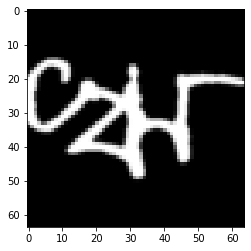

In [5]:
## Visualizing an img ##

# Picking a random integer #

idx = int(np.random.randint(low = 0 , high = len(bangla_dataset) , size = 1))

# Getting img and label #

img , label = bangla_dataset[idx]

# Displaying the image and also printing the label #

print('Label is :' , label)

plt.imshow(denormalize_img(img).permute(1 , 2 , 0))
plt.show()

Nice!!

This is 'eh' letter in Bengali language. Since, I am a bengali I do know the letters, so yeah now lets move on and set our dataloader.

In [6]:
## Setting dataloader ##

bangla_dataloader = DataLoader(dataset = bangla_dataset,
                               shuffle = True,
                               batch_size = 64)

## Checking the dataloader length ##

print('The dataloader is' , len(bangla_dataloader) , 'batches long!')

The dataloader is 2596 batches long!


Now lets visualize a batch of data.

We are going to utilize `make_grid` to do that.

In [7]:
## Defining visualization utility function ##

def view_img(img):
    
    fig , ax = plt.subplots(figsize = (8 , 8))
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    plt.imshow(make_grid(denormalize_img(img.to('cpu')) , 8).permute(1 , 2 , 0))
    plt.show()

Now lets view a batch of image.

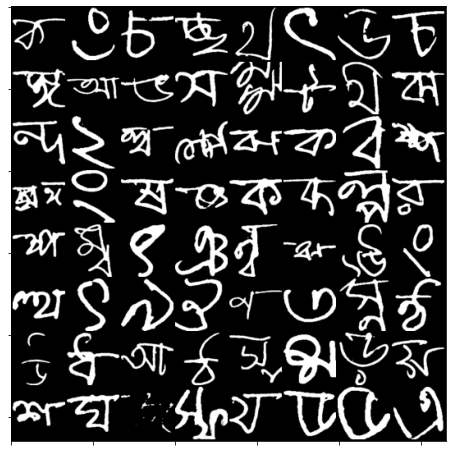

In [8]:
## Visualizing a batch of image ##

for img , label in bangla_dataloader:
    
    view_img(img)
    
    break

Now, we are going to transfer the dataloader into GPU.

For that we need have some utility functions for transferring data to GPU.

In [9]:
## Utility functions for data transfer to GPU ##

def get_device():
    
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

def transfer_data(data , device):
    
    if isinstance(data , (tuple , list)):
        return [transfer_data(each_data , device) for each_data in data]
    return data.to(device)

Now lets define our GPU Dataloader class.

In [10]:
## GPU Dataloader ##

class GPUDataloader:
    
    def __init__(self , dl , device):
        
        self.dl = dl
        self.device = device
        
        
    def __iter__(self):
        
        for batch in self.dl:
            yield transfer_data(batch , self.device)
            
            
    def __len__(self):
        
        return len(self.dl) 

Now lets set our dataloader.

In [11]:
## Setting our GPU Dataloader ##

device = get_device()

bangla_dl = GPUDataloader(bangla_dataloader , device)

print('The datalaoder is' , len(bangla_dl) , 'long!')

The datalaoder is 2596 long!


Now to further evaluate if we have implemented our dataloader properly lets visualize a batch of data.

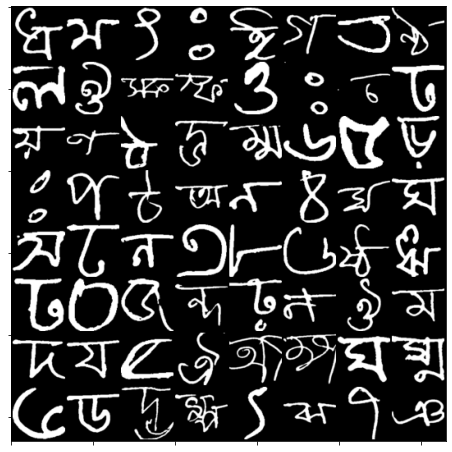

In [12]:
## Visualizing the dataloader ##

for img , label in bangla_dl:
    
    view_img(img)
    
    break

So, its working properly.

Now its time to get our hands dirty with the model creation.

Lets do that!

In [13]:
## Defining Generator ##

class Generator(nn.Module):
    
    def __init__(self , z_dim , img_dim , hidden_dim = 64):
        
        super().__init__()
        
        self.gen = nn.Sequential(
        ## Making 4 * 4 ##
        nn.ConvTranspose2d(in_channels = z_dim , out_channels = hidden_dim * 4 , kernel_size = 4 , 
                           stride = 1 , padding = 0 , bias = False),    
        nn.BatchNorm2d(num_features = hidden_dim * 4),
        
        ## Making 8 * 8 ##    
        nn.ConvTranspose2d(in_channels = hidden_dim * 4 , out_channels = hidden_dim * 4 , kernel_size = 4 , 
                           stride = 2 , padding = 1 , bias =False),
        nn.BatchNorm2d(num_features = hidden_dim * 4),
        nn.ReLU(),
        
        ## Making 16 * 16 ##    
        nn.ConvTranspose2d(in_channels = hidden_dim * 4 , out_channels = hidden_dim * 4 , kernel_size = 4 , 
                           stride = 2 , padding = 1 , bias =False),
        nn.BatchNorm2d(num_features = hidden_dim * 4),
        nn.ReLU(),
        
        ## Making 32 * 32 ##     
        nn.ConvTranspose2d(in_channels = hidden_dim * 4 , out_channels = hidden_dim * 2 , kernel_size = 4 , 
                           stride = 2 , padding = 1 , bias =False),
        nn.BatchNorm2d(num_features = hidden_dim * 2),
        nn.ReLU(),
            
        ## Making 64 * 64 ##
        nn.ConvTranspose2d(in_channels = hidden_dim * 2 , out_channels = hidden_dim , kernel_size = 4 , 
                           stride = 2 , padding = 1 , bias =False),
        nn.BatchNorm2d(num_features = hidden_dim),
        nn.ReLU(),
            
        ## Making image ##
        nn.ConvTranspose2d(in_channels = hidden_dim , out_channels = img_dim , kernel_size = 3 , 
                           stride = 1 , padding = 1),
        nn.Tanh()
        )
        
    def forward(self , noise):
        
        return self.gen(noise.view(noise.shape[0] , noise.shape[1] , 1 , 1))

In [14]:
## Lets instantiate generator ##

gen_model = Generator(1024 , 3).to(device)

Now its better to test the Generator.

In [15]:
## Testing the generator ##

def test():
    
    some_noise = torch.randn(32 , 1024).to(device)
    
    preds = gen_model(some_noise)
    
    print('The prediction is of shape :' , preds.shape)
    
test()

The prediction is of shape : torch.Size([32, 3, 64, 64])


Now its time to formulate our discriminator.

In [16]:
## Defining our discriminator ##

class Discriminator(nn.Module):
    
    def __init__(self , img_dim = 3 , out_dim = 1, hidden_dim = 64):
        
        super().__init__()
        
        self.disc = nn.Sequential(
            nn.Conv2d(in_channels = img_dim , out_channels = hidden_dim , kernel_size = 3,
                      padding = 1 , stride = 1 , bias = False),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2),
            
            ## 32 *32 * 128 ##
            nn.Conv2d(in_channels = hidden_dim , out_channels = hidden_dim * 2 , kernel_size = 4,
                      padding = 1 , stride = 2 , bias = False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2),
                                  
            ## 16 * 16 * 256
            nn.Conv2d(in_channels = hidden_dim * 2 , out_channels = hidden_dim * 4 , kernel_size = 4,
                      padding = 1 , stride = 2 , bias = False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2),
            
            ## 8 * 8 * 512##                      
            nn.Conv2d(in_channels = hidden_dim * 4 , out_channels = hidden_dim * 8 , kernel_size = 4,
                      padding = 1 , stride = 2 , bias = False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.LeakyReLU(0.2),
            
            ## 4 * 4 * 1024 ##
            nn.Conv2d(in_channels = hidden_dim * 8 , out_channels = hidden_dim * 16 , kernel_size = 4,
                      padding = 1 , stride = 2 , bias = False),
            nn.BatchNorm2d(hidden_dim * 16),
            nn.LeakyReLU(0.2),
            
            ## 1 * 1 * 1 ##
            nn.Conv2d(in_channels = hidden_dim * 16 , out_channels = out_dim , kernel_size = 4,
                      padding = 0 , stride = 1)
        )
        
    def forward(self , img):
        
        return self.disc(img)

In [17]:
## Instantiating the discriminator model ##

disc_model = Discriminator().to(device)

Now its better to test the model.

In [18]:
## Testing the discriminator ##

def disc_test():
    
    some_noise = torch.randn(32 , 1024).to(device)
    
    gen_preds = gen_model(some_noise)
    
    print('The generator prediction is of shape :' , gen_preds.shape)
    
    disc_preds = disc_model(gen_preds)
    
    print('The discriminator prediction is of shape :' , disc_preds.shape)

In [19]:
## Finally checking it ##

disc_test()

The generator prediction is of shape : torch.Size([32, 3, 64, 64])
The discriminator prediction is of shape : torch.Size([32, 1, 1, 1])


Now with that we have modelled our GAN.

But a couple of things still remain.

- [ ] Noise Generation utility function.
- [ ] Loss Function definition.
- [ ] Optimizers setup.

In [20]:
## Noise Generator ##

def generate_noise(batch_size , z_dim = 1024):
    
    noise = torch.randn(batch_size , z_dim).to(device)
    
    return noise

In [21]:
## Loss function ##

## Inhibits the major difference from DCGAN paper ##

def criterion(inp , target):
    
    loss = (1/2) * torch.mean((inp - target) ** 2)
    
    return loss

In [22]:
## Optimizers ##

gen_optim = torch.optim.Adam(gen_model.parameters() , lr = 0.0002 , betas = (0.5 , 0.999))

disc_optim = torch.optim.Adam(disc_model.parameters() , lr = 0.0002 , betas = (0.5 , 0.999))

Now we are ready to train.

Epochs : 1 / 20 --> Discriminator Loss : 0.210 , Generator Loss : 0.088


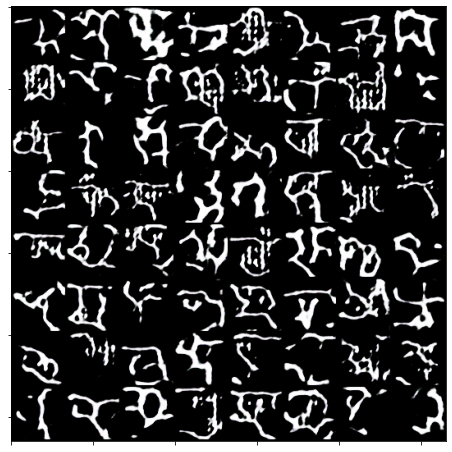

Epochs : 2 / 20 --> Discriminator Loss : 0.063 , Generator Loss : 0.428


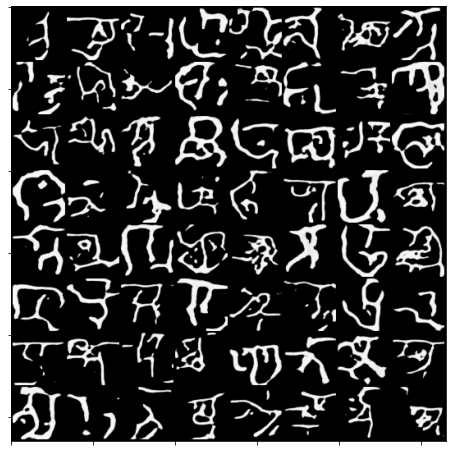

Epochs : 3 / 20 --> Discriminator Loss : 0.026 , Generator Loss : 0.376


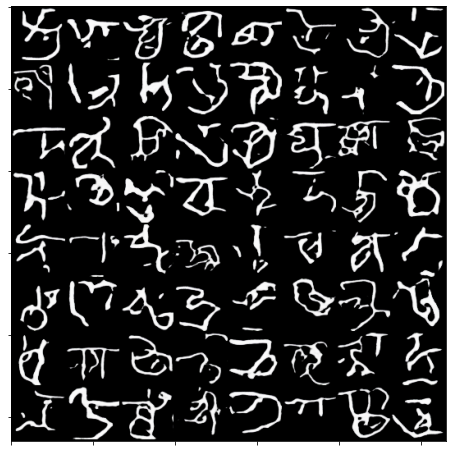

Epochs : 4 / 20 --> Discriminator Loss : 0.039 , Generator Loss : 0.281


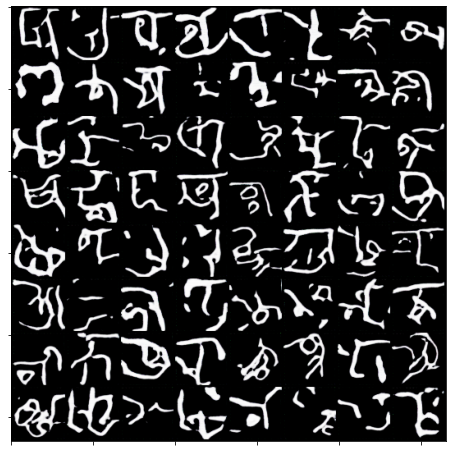

Epochs : 5 / 20 --> Discriminator Loss : 0.071 , Generator Loss : 0.302


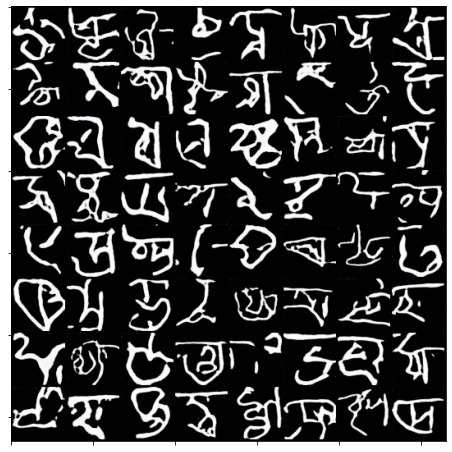

Epochs : 6 / 20 --> Discriminator Loss : 0.251 , Generator Loss : 0.093


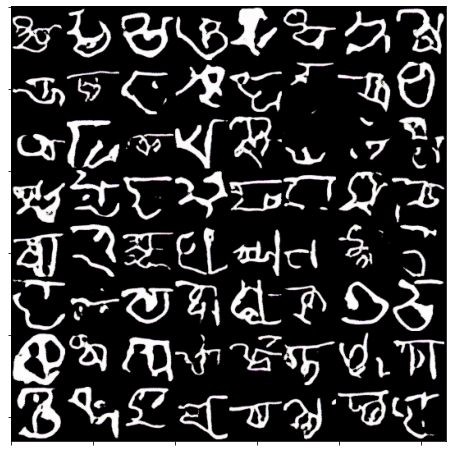

Epochs : 7 / 20 --> Discriminator Loss : 0.008 , Generator Loss : 0.765


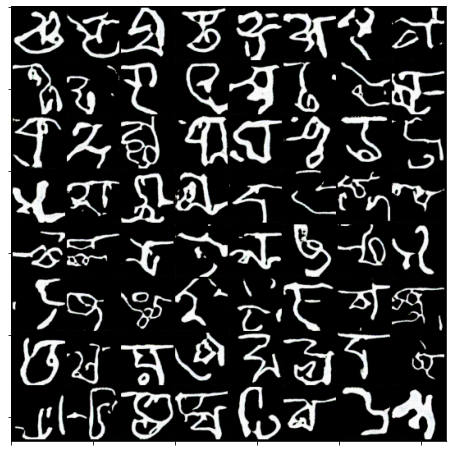

Epochs : 8 / 20 --> Discriminator Loss : 0.111 , Generator Loss : 0.243


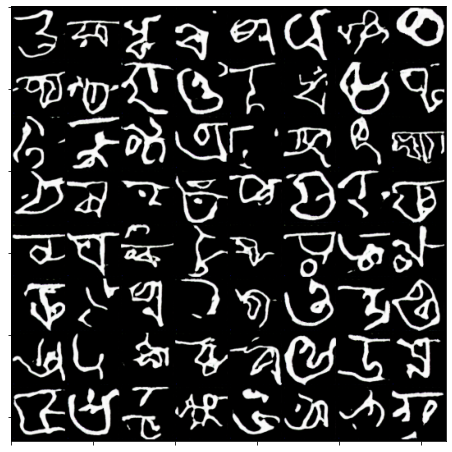

Epochs : 9 / 20 --> Discriminator Loss : 0.019 , Generator Loss : 0.550


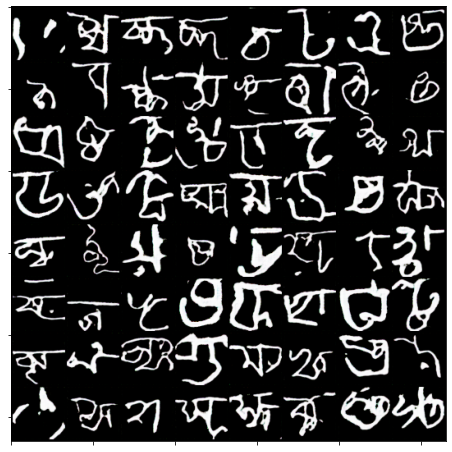

Epochs : 10 / 20 --> Discriminator Loss : 0.009 , Generator Loss : 0.563


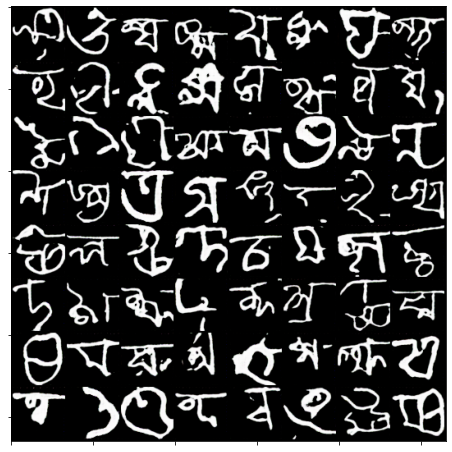

Epochs : 11 / 20 --> Discriminator Loss : 0.020 , Generator Loss : 0.565


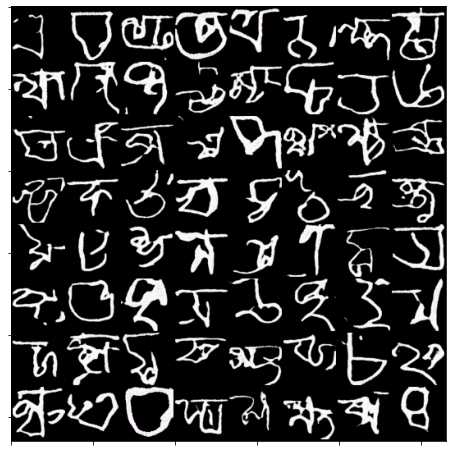

Epochs : 12 / 20 --> Discriminator Loss : 0.026 , Generator Loss : 0.303


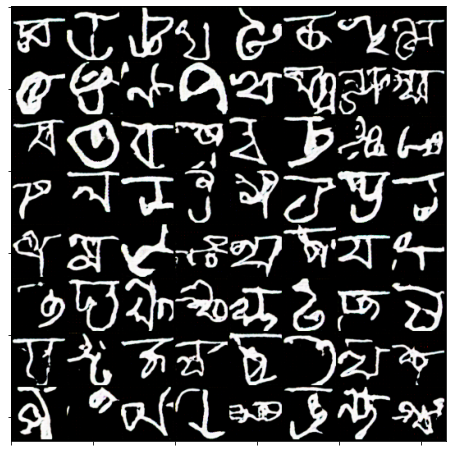

Epochs : 13 / 20 --> Discriminator Loss : 0.032 , Generator Loss : 0.579


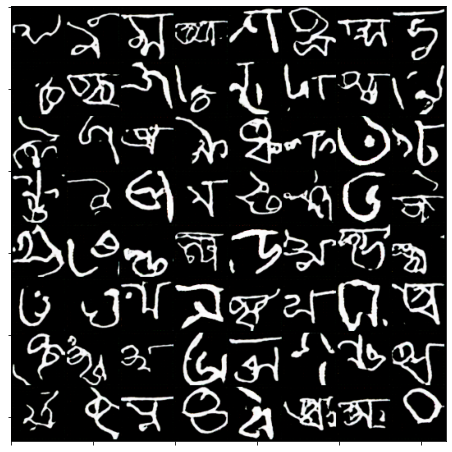

Epochs : 14 / 20 --> Discriminator Loss : 0.018 , Generator Loss : 0.603


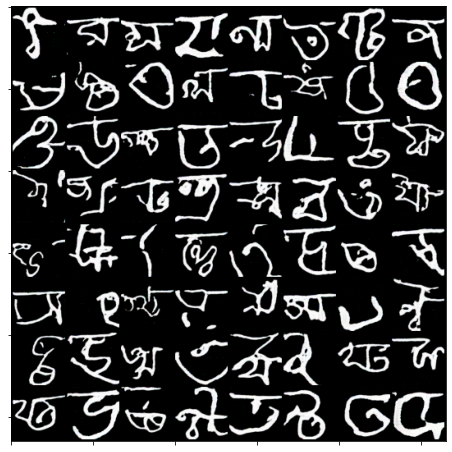

Epochs : 15 / 20 --> Discriminator Loss : 0.053 , Generator Loss : 0.523


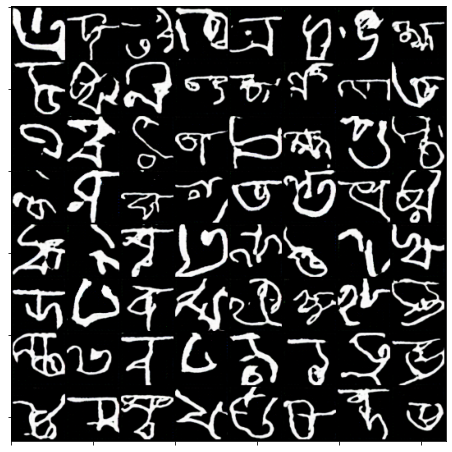

Epochs : 16 / 20 --> Discriminator Loss : 0.021 , Generator Loss : 0.625


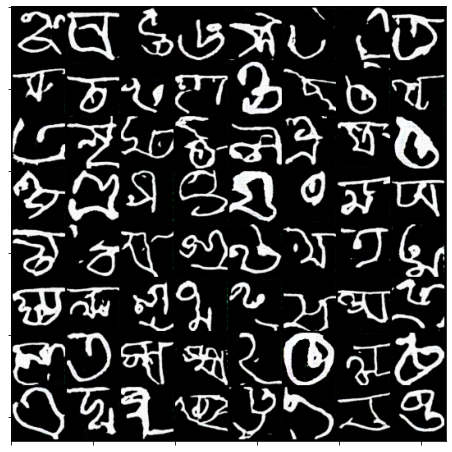

Epochs : 17 / 20 --> Discriminator Loss : 0.025 , Generator Loss : 0.388


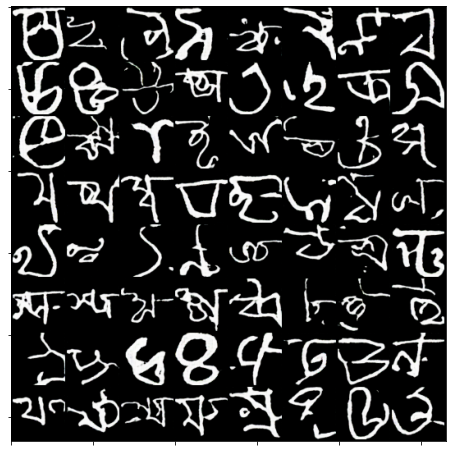

Epochs : 18 / 20 --> Discriminator Loss : 0.036 , Generator Loss : 0.266


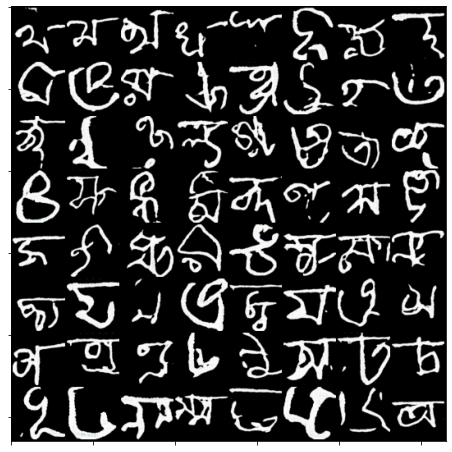

Epochs : 19 / 20 --> Discriminator Loss : 0.009 , Generator Loss : 0.267


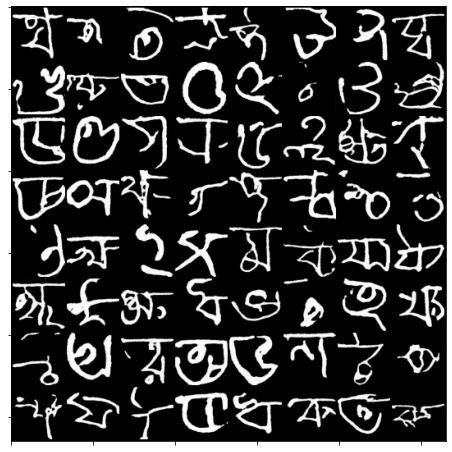

Epochs : 20 / 20 --> Discriminator Loss : 0.015 , Generator Loss : 0.506


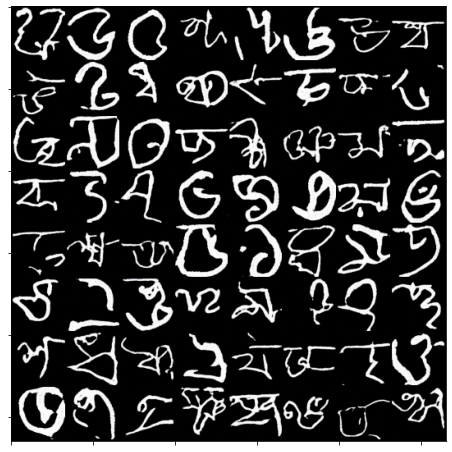

In [23]:
num_epochs = 20

for epoch in range(num_epochs):
    
    for img , _ in bangla_dl:
        
        batch_size = len(img)
        
        disc_model.train()
        gen_model.train()
        
        ## Discriminator training ##
        
        disc_noise = generate_noise(batch_size)
        
        fake_img = gen_model(disc_noise).detach()
        
        fake_pred = disc_model(fake_img)
        
        fake_target = torch.zeros_like(fake_pred)
        
        fake_loss = criterion(fake_pred , fake_target)
        
        real_pred = disc_model(img)
        
        real_target = torch.ones_like(real_pred)
        
        real_loss = criterion(real_pred , real_target)
        
        disc_loss = (fake_loss + real_loss)
        
        disc_optim.zero_grad()
        
        disc_loss.backward()
        
        disc_optim.step()
        
        
        ## Generator Training ##
        
        gen_noise = generate_noise(batch_size)
        
        gen_img = gen_model(gen_noise)
        
        gen_pred = disc_model(gen_img)
        
        gen_target = torch.ones_like(gen_pred)
        
        gen_loss = criterion(gen_pred , gen_target)
        
        gen_optim.zero_grad()
        
        gen_loss.backward()
        
        gen_optim.step()
        
    print('Epochs : {} / {} --> Discriminator Loss : {:.3f} , Generator Loss : {:.3f}'.format(epoch + 1 , num_epochs , 
                                                                                              disc_loss.item() , 
                                                                                              gen_loss.item()))
    
    gen_model.eval()
    
    some_noise = generate_noise(batch_size = 64)
    
    some_img = gen_model(some_noise).detach()
    
    view_img(some_img)

In [24]:
## Saving the models ##

torch.save(gen_model , 'generator.pth')
torch.save(disc_model , 'discriminator.pth')

That's it :)

You can take the models and train to make it better.